In [1]:
from keras.models import load_model
from keras import backend as K
K.set_image_dim_ordering('th')

model = load_model('vgg16.h5')

Using TensorFlow backend.
/home/kaixi/.local/lib/python3.5/site-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
model.layers[4].output

<tf.Tensor 'conv2d_2/Relu:0' shape=(?, 64, 224, 224) dtype=float32>

In [65]:
import tensorflow as tf
from keras.models import Model
from keras.layers.convolutional import UpSampling2D, ZeroPadding2D, Conv2D
from keras.layers.local import LocallyConnected1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Input, Lambda, Flatten, Dense, Reshape
from keras.layers.merge import concatenate
#from keras.layers.activation import softmax
from keras.optimizers import SGD
import keras.activations
import numpy as np

# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py#L19
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def addConv(x, n, filters, activation='relu', extra_layer=None):
    for _ in range(n):
        x = ZeroPadding2D(1)(x)
        x = Conv2D(filters, 3)(x)
        x = BatchNormalization()(x)
        if activation:
            x = Activation(activation) (x)
        if extra_layer:
            x = extra_layer(x)
    return x
def maxout(x):
    return tf.reduce_max(x, reduction_indices=1, keep_dims=False)

inp = Input(shape=(1,224,224))
inp0 = Lambda(lambda y:tf.tile(y,[1,3,1,1])) (inp)

m = Model(inputs = model.inputs, outputs = model.layers[16].output)
m.trainable = False
x = m(inp0)

size_224 = m.layers[3].output
size_112 = m.layers[9].output
m_112 = Model(inputs = model.inputs, outputs = model.layers[9].output)
m_112.trainable = False
x_112 = m_112(inp0)
m_224 = Model(inputs = model.inputs, outputs = model.layers[4].output)
m_224.trainable = False
x_224 = m_224(inp0)
print(x)

x = UpSampling2D(2)(x)
print(x)
x = addConv(x, 2, 64)
x = concatenate([x,x_112],axis=1)


'''
x = UpSampling2D(2)(x)
x = addConv(x, 2, 64)

x = UpSampling2D(2)(x)
x = addConv(x, 2, 64)
'''
x = UpSampling2D(2)(x)
x = addConv(x, 1, 64)

x = concatenate([x,x_224],axis=1)

x = addConv(x, 2, 64)
#x = addConv(x,2,2,maxout)

x = addConv(x, 1, 2,'softmax')
print(x)
x = Lambda(maxout) (x)
x= Reshape((224,224))(x)

m2 = Model(inputs = inp, outputs = x)
sgd = SGD(lr=1e1)
#m2.summary()
m2.compile(loss=dice_coef_loss, optimizer='adadelta',metrics=[dice_coef,'accuracy'])
#m2.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=['binary_crossentropy'])

Tensor("model_98/conv2d_7/Relu:0", shape=(?, 256, 56, 56), dtype=float32)
Tensor("up_sampling2d_51/transpose_1:0", shape=(?, 256, 112, 112), dtype=float32)
Tensor("activation_141/truediv:0", shape=(?, 2, 224, 224), dtype=float32)


In [66]:
m2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_30 (InputLayer)            (None, 1, 224, 224)   0                                            
____________________________________________________________________________________________________
lambda_35 (Lambda)               (None, 3, 224, 224)   0           input_30[0][0]                   
____________________________________________________________________________________________________
model_98 (Model)                 (None, 256, 56, 56)   1735488     lambda_35[0][0]                  
____________________________________________________________________________________________________
up_sampling2d_51 (UpSampling2D)  (None, 256, 112, 112) 0           model_98[1][0]                   
___________________________________________________________________________________________

In [9]:
np.concatenate((train_y,train_y),axis=1).shape

NameError: name 'train_y' is not defined

In [24]:
from scipy.misc import imresize
def preprocess_labels(labels):
    pos = np.where(labels==1)
    new_labels = np.concatenate((labels,labels),axis=1)
    new_labels.fill(0)
    new_labels[:,0]= 1
    new_labels[pos[0], 0, pos[2],pos[3]] = 0
    new_labels[pos[0], 1, pos[2],pos[3]] = 1
    #new_labels = new_labels.transpose((2,0,1))
    return new_labels

def preprocess(mri_slice):
    img0 = imresize(mri_slice, (224,224))
    img0.resize((img0.shape[0],img0.shape[1],1))
    img0 = img0.transpose((2,0,1))
    return np.expand_dims(img0, axis=0)

In [66]:
#f = h5py.File('dataset_1_equal.h5', 'r')
#train_y = f['train_y'][:end]
#f.close()
#pre = train_y.reshape(train_y.shape[0],train_y.shape[2],train_y.shape[3])
np.where(pre==None)
#np.where(train_y==None)
#pre = preprocess_labels1(train_y)
#img = pre[18]
#pos = np.where(np.argmax(img, axis=0)>0)
#img1 = np.zeros((img.shape[1],img.shape[2]))
#img1[pos[0],pos[1]] = 1
#print(img1.shape)
#plt.imshow(img1)
#m2.reset_states()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(array([], dtype=int64),)

In [68]:
import h5py
cont = 100
initial_epoch = 5
epochs = 5
for i in range(0,100,100):
    start = cont+i
    end = start+100
    with h5py.File('dataset_1_patches_only.h5', 'r') as f:
        train_x = f['train_x'][start:end]
        #train_y = preprocess_labels(f['train_y'][start:end])
        train_y = f['train_y'][start:end]
        train_y = train_y.reshape(train_y.shape[0],train_y.shape[2],train_y.shape[3])
        print (train_y.shape)
        #print(m2.evaluate(train_x[0:1],train_y[0:1],batch_size=5))
        m2.fit(train_x,train_y,epochs=initial_epoch+epochs,batch_size=5,initial_epoch=initial_epoch,shuffle="batch")
        #draw_fig(fig,ax)
    initial_epoch+=epochs

(100, 224, 224)
Epoch 6/10
100/100 [==============================] - 24s - loss: -0.0113 - dice_coef: 0.0113 - acc: 0.0028         

In [15]:
def draw_fig(fig,ax):
    fig.clear()
    img= m2.predict(preprocess(mri_data[predict_slide])).squeeze()
    ax.imshow(imresize(mri_data[predict_slide], (224,224)),cmap=plt.cm.gray)
    ax.imshow(np.ma.masked_where(img1<.5, img1),alpha=.7,cmap=plt.cm.autumn, interpolation='none')
    print (img.sum())

In [58]:
img.max()

0.9999994

In [27]:
# Get image data w/ nibabel
import nibabel as nib
def get_data(filename):
    img = nib.load(filename)
    return img.get_data()
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))    
mri_data = scale(get_data('../data/case_046_2.nii.gz')).transpose((2,0,1))
labelled_data = get_data('../data/case_046_labels.nii.gz').transpose((2,0,1))

In [38]:
img.shape

(224, 224)

(307.16681, 0.99796176)

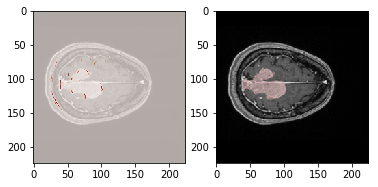

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

predict_slide = 140

img= m2.predict(preprocess(mri_data[predict_slide])).squeeze()
img1 = img
#pos = np.where(np.argmax(img, axis=0)>0)
#img1 = np.zeros((img.shape[1],img.shape[2]))
#img1[pos[0],pos[1]] = img[1,pos[0],pos[1]]
#img1/=img1.max()
fig, ax = plt.subplots(1,2)
#fig.set_size_inches(15,15)
ax[0].imshow(imresize(mri_data[predict_slide], (224,224)),cmap=plt.cm.gray)
#ax[0].imshow(np.ma.masked_where(img1<=np.average(img1)+np.std(img1), img1),alpha=.7,cmap=plt.cm.Reds, interpolation='none')
ax[0].imshow(np.ma.masked_where(img1<=0, img1),alpha=.7,cmap=plt.cm.Reds, interpolation='none')

# Show original
ax[1].imshow(imresize(mri_data[predict_slide], (224,224)),cmap=plt.cm.gray)
labels = imresize(labelled_data[predict_slide],(224,224))
ax[1].imshow(np.ma.masked_where(labels<=0, labels),cmap=plt.cm.autumn, alpha=0.1)
img1.sum(),img.max()

In [103]:
ax.shape

(2,)

In [7]:
import nibabel as nib
import numpy as np
from scipy.misc import imresize
def get_data(filename):
    img = nib.load(filename)
    return img.get_data()
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))    
def load(s):
    return get_data('../data/case_%s_2.nii.gz'%s).transpose((2,0,1)), get_data('../data/case_%s_labels.nii.gz'%s).transpose((2,0,1))
def preprocess(mri_slice):
    img0 = imresize(mri_slice, (224,224))
    img0.resize((img0.shape[0],img0.shape[1],1))
    img0 = img0.transpose((2,0,1))
    return np.expand_dims(img0, axis=0)
def get_testing_data(s):
    x, y = load(s)
    
    x = scale(x)
    
    x1 = np.zeros((x.shape[0],1,224, 224,))
    y1 = np.zeros(x1.shape)
    
    for n in range(x.shape[0]):
        x1[n] = preprocess(x[n])
        y1[n] = preprocess(y[n])
    return x1, y1
def get_training_data(s, slice_filter="equal"):
    print("Getting data for",s)
    x, y = load(s)
    
    x_sums_by_slice = x.sum(axis=(1,2)) # used to avoid completely blank slices
    y_sums_by_slice = y.sum(axis=(1,2))
    
    # Get slice #s for slices with/out patches
    patch_slices = np.where(y_sums_by_slice>0)[0]
    non_patch_slices = np.where((y_sums_by_slice==0) & (x_sums_by_slice>0))[0]
    np.random.shuffle(non_patch_slices)
        
    # Filter
    if slice_filter == "equal":
        #print (non_patch_slices)
        non_patch_slices = non_patch_slices[:patch_slices.size]
        #print (non_patch_slices)
    if slice_filter == "patches_only":
        non_patch_slices = []
    
    all_slices = np.concatenate((patch_slices,non_patch_slices)).astype(int)
    all_slices.sort()
    
    # preprocess data    
    x = scale(x)
    
    x1 = np.zeros((all_slices.size,1,224, 224,))
    y1 = np.zeros(x1.shape)
    
    for n,slice_n in enumerate(all_slices):
        x1[n] = preprocess(x[slice_n])
        y1[n] = preprocess(y[slice_n])
    
    return x1, preprocess_labels(y1)

In [4]:
import glob
def get_case_num(name):    
    return name[name.find("case_")+len("case_"):name.find("_labels")]

all_cases = []
for name in glob.glob('../data/*labels.nii.gz'):
    print(name,get_case_num(name))
    all_cases.append(get_case_num(name))
all_cases.sort()

../data/case_021_labels.nii.gz 021
../data/case_011_labels.nii.gz 011
../data/case_018_labels.nii.gz 018
../data/case_047_labels.nii.gz 047
../data/case_055_labels.nii.gz 055
../data/case_035_labels.nii.gz 035
../data/case_007_labels.nii.gz 007
../data/case_039_labels.nii.gz 039
../data/case_019_labels.nii.gz 019
../data/case_008_labels.nii.gz 008
../data/case_053_labels.nii.gz 053
../data/case_004_labels.nii.gz 004
../data/case_058_labels.nii.gz 058
../data/case_028_labels.nii.gz 028
../data/case_017_labels.nii.gz 017
../data/case_010_labels.nii.gz 010
../data/case_002_labels.nii.gz 002
../data/case_034_labels.nii.gz 034
../data/case_014_labels.nii.gz 014
../data/case_001_labels.nii.gz 001
../data/case_046_labels.nii.gz 046
../data/case_009_labels.nii.gz 009
../data/case_005_labels.nii.gz 005
../data/case_013_labels.nii.gz 013
../data/case_052_labels.nii.gz 052
../data/case_003_labels.nii.gz 003


In [28]:
import h5py
cont = 100
initial_epoch = 1
epochs = 5
for case in all_cases[:5]:
    train_x,train_y = get_training_data(case,'all')
    m2.fit(train_x,train_y,epochs=initial_epoch+epochs,batch_size=5,initial_epoch=initial_epoch,shuffle="batch")
    initial_epoch+=epochs

Getting data for 001
Epoch 2/6
33/33 [==============================] - 10s - loss: 2.9432 - binary_crossentropy: 2.9432     
Epoch 3/6
33/33 [==============================] - 8s - loss: 2.7193 - binary_crossentropy: 2.7193     

In [78]:
from keras.models import load_model
m3 = load_model('Model_unet_case1-5_5ep.h5')